# Question 1

## Importing Necessory Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns

In [2]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


## Some Useful Functions

1. **tsplot :** Plots the Series, ADFuller p_value, ACF and PACF plots
2. **plot_forecast :** Plots the Train, Test, Predicted Values with MAE, MAPE values

In [3]:
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

In [4]:
def plot_forecast(series_train, series_test, forecast, forecast_int=None):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=(12, 6))
    plt.title(f"MAE: {mae:.2f}, MAPE: {mape:.3f}", size=18)
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return mae, mape

### Importing and Proccesing Data to requried format

1. **IMPORT DATA**
3. **Convert String into datetime object**
2. **Split Entry and Exit Data**



In [5]:
#Importing the dataset
df = pd.read_csv('air-traffic-prediction/parkingLot (1).csv')

#Change the timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

#Seperating entry and exit data
entry_df = df[df["camera_id"] == 1]
exit_df = df[df["camera_id"] == 2]
print(entry_df.shape)
print(exit_df.shape)



(53347, 3)
(53347, 3)


## Part 1A

### SubTotaling the data day_wise and Creating Test Trainsplit

In [6]:
#Resampling the data to get the number of cars entering the parking lot per day
ent = entry_df.set_index('timestamp', inplace= False)
day_wise_df = pd.Series(ent.resample('D').size())

print(day_wise_df)

timestamp
2024-09-12     886
2024-09-13     809
2024-09-14     925
2024-09-15    1073
2024-09-16     843
              ... 
2024-11-09     906
2024-11-10     944
2024-11-11     828
2024-11-12     806
2024-11-13     781
Freq: D, Length: 63, dtype: int64


In [7]:
#Splitting the data into train and test set

train_size = len(day_wise_df) - 7
train, test = day_wise_df[:train_size], day_wise_df[train_size:]

print("Train set size:", len(train))
print("Test set size:", len(test))

Train set size: 56
Test set size: 7


### Plotting the Data

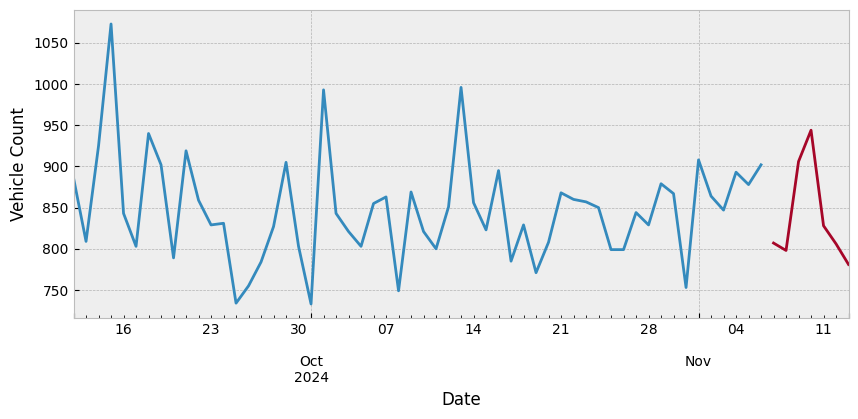

In [8]:

fig, ax = plt.subplots(figsize=(10, 4))
train.plot(ax =ax, label = 'Train Data')
test.plot(ax =ax, label = 'Test Data')
ax.set_xlabel('Date')
ax.set_ylabel('Vehicle Count')
plt.show()

### Analysing for Trend and Seasonality

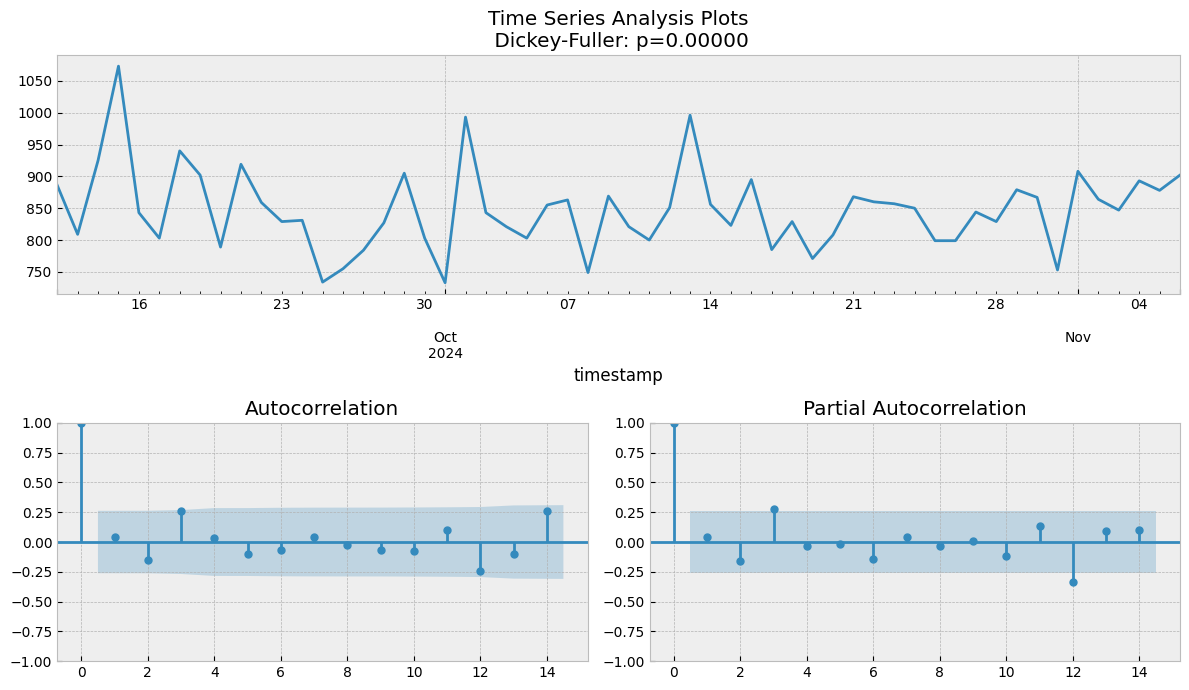

In [9]:
tsplot(train, lags=14)

**Correlation Ananlysis**

From the graphs if seems to have no correlation, and there isnt any correlation even with the lag 7 impling Low probability of data being seasonal

We try to confirm non-seasonality by other means

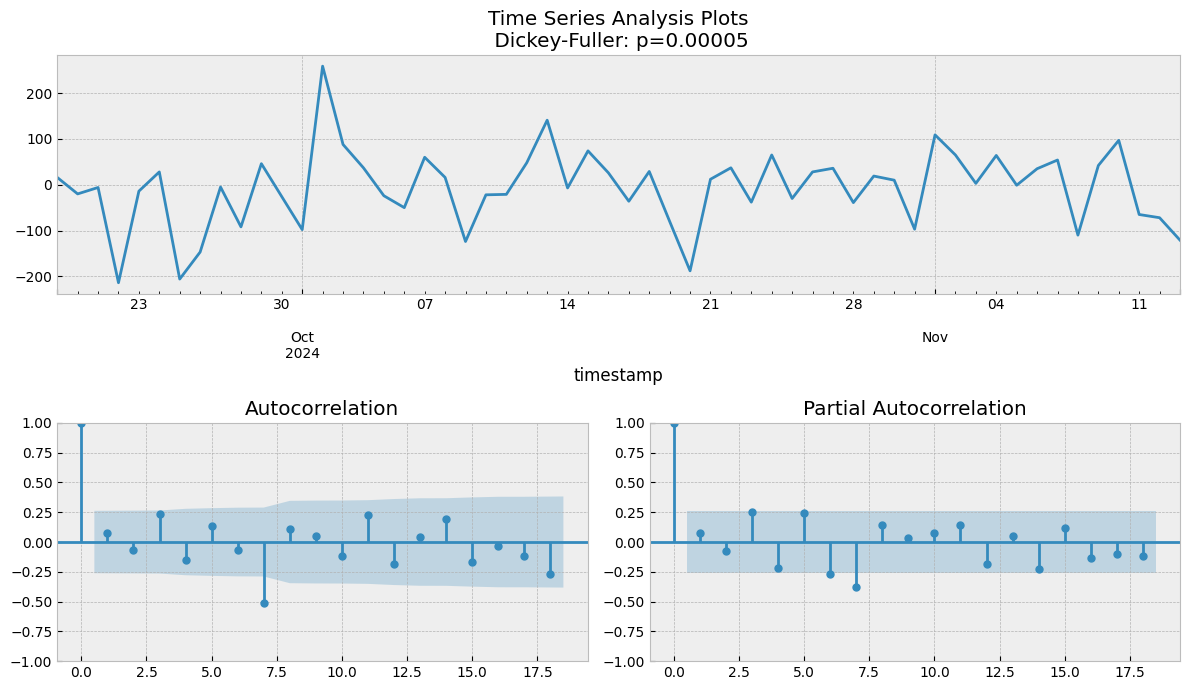

In [10]:
S = day_wise_df - day_wise_df.shift(7)
S = S.dropna()
tsplot(S)

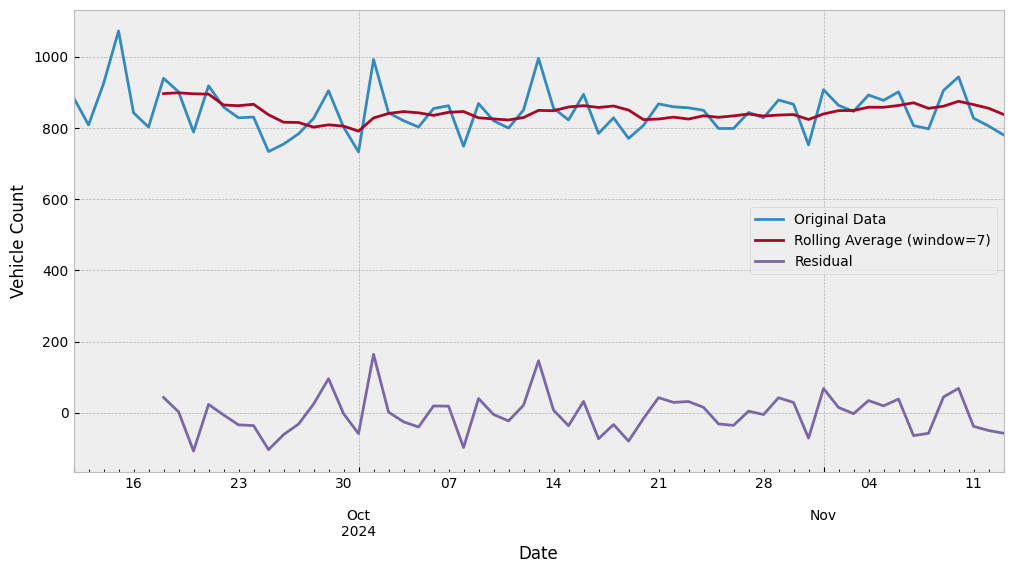

In [11]:
# Calculate rolling average and residual
rolling_avg = day_wise_df.rolling(window=7).mean()
residual = day_wise_df - rolling_avg

# Plot the original data, rolling average, and residual
fig, ax = plt.subplots(figsize=(12, 6))

day_wise_df.plot(ax=ax, label='Original Data')
rolling_avg.plot(ax=ax, label='Rolling Average (window=7)')
residual.plot(ax=ax, label='Residual')

ax.set_xlabel('Date')
ax.set_ylabel('Vehicle Count')
ax.legend()

plt.show()

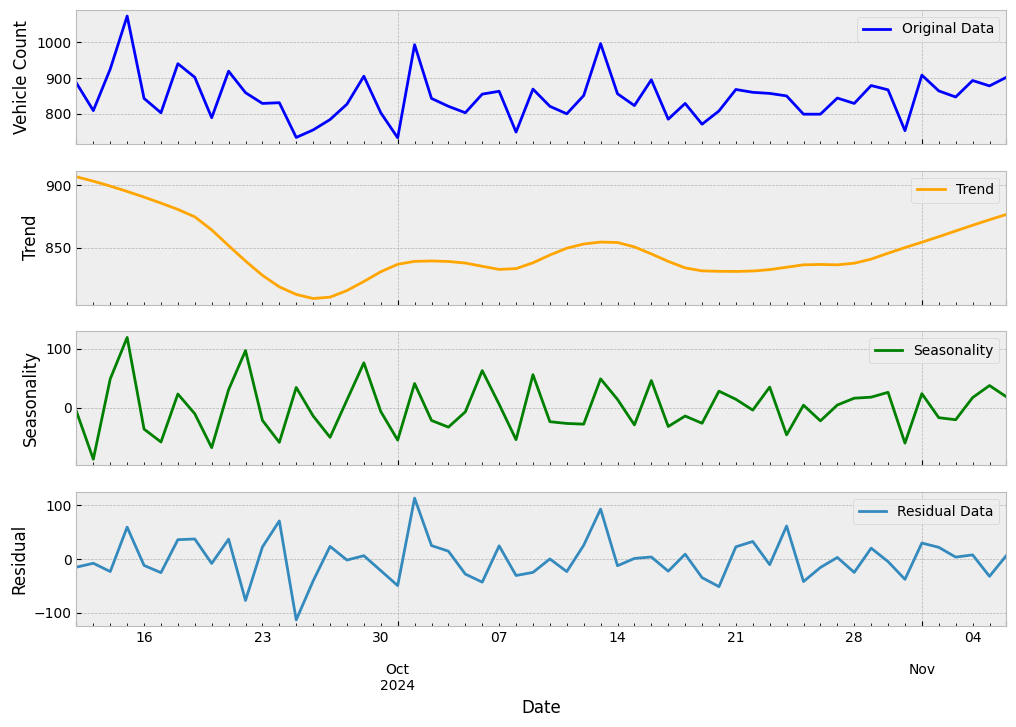

In [12]:
# Perform STL decomposition
stl = sm.tsa.STL(train, seasonal=7)
result = stl.fit()

# Extract the components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the components
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

train.plot(ax=axs[0], label='Original Data', color='blue')
axs[0].set_ylabel('Vehicle Count')
axs[0].legend()

trend.plot(ax=axs[1], label='Trend', color='orange')
axs[1].set_ylabel('Trend')
axs[1].legend()

seasonal.plot(ax=axs[2], label='Seasonality', color='green')
axs[2].set_ylabel('Seasonality')
axs[2].legend()


residual.plot(ax=axs[3], label='Residual Data')
axs[3].set_ylabel('Residual')
axs[3].legend()


plt.xlabel('Date')
plt.show()

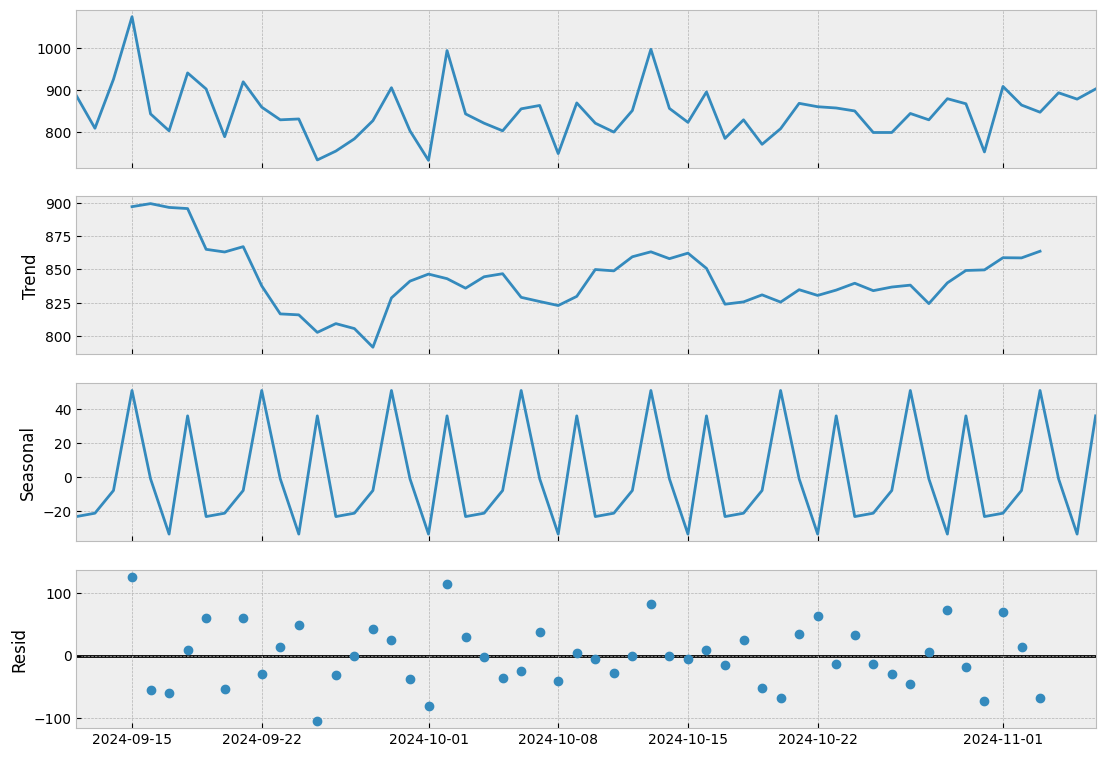

In [13]:
# Perform seasonal decomposition
stl = sm.tsa.seasonal_decompose(train)
result = stl.plot()
result.set_size_inches(12, 8)
plt.show()

The Data seems to have a sesonal trend unlike expected

### Fitting Models

1. **Exponential Smoothening**
2. **SARIMA**

Exponential Smoothing model seems the model of choice as the ACF and PACF plot show no corelation and all lags

In [14]:
# Fit the ETS model
ets_model_train = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7).fit()
ets_forecast = ets_model_train.forecast(len(test))

# Display the summary of the model
print(ets_model_train.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                     None   No. Observations:                   56
Model:             ExponentialSmoothing   SSE                         204012.232
Optimized:                         True   AIC                            481.233
Trend:                         Additive   BIC                            503.512
Seasonal:                      Additive   AICC                           489.899
Seasonal Periods:                     7   Date:                 Sun, 19 Jan 2025
Box-Cox:                          False   Time:                         20:41:20
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1088565                alpha                 True
smoothing_trend          

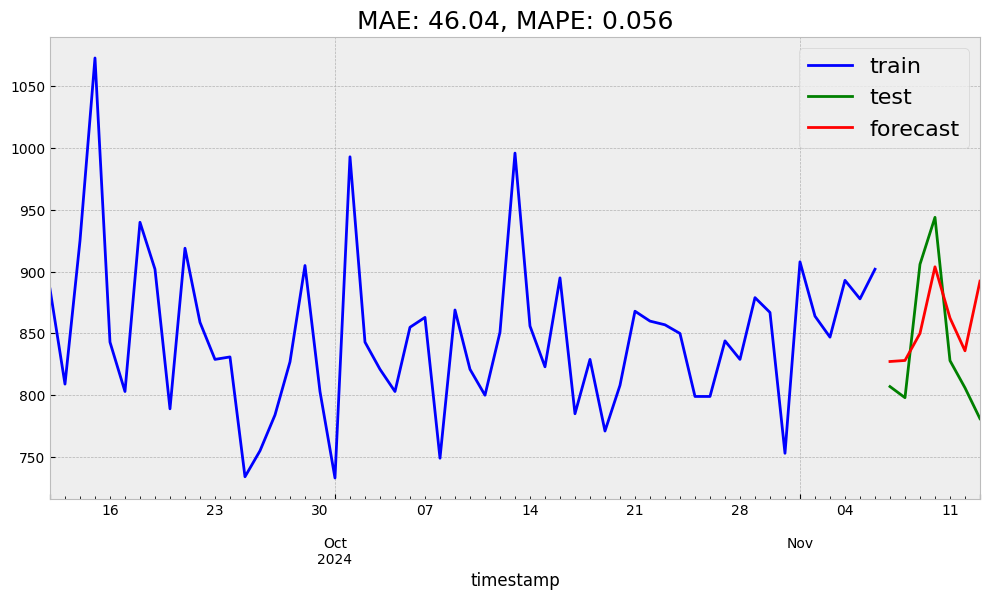

In [15]:
#Ploting the Forecast
mae_ets, mape_ets = plot_forecast(train, test, ets_forecast)

Also Trying to fit an SARIMA model

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   56
Model:              ARIMA(3, 1, 0, 7)   Log Likelihood                -274.497
Date:                Sun, 19 Jan 2025   AIC                            556.995
Time:                        20:41:21   BIC                            564.562
Sample:                    09-12-2024   HQIC                           559.866
                         - 11-06-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.8280      0.174     -4.759      0.000      -1.169      -0.487
ar.S.L14      -0.4065      0.252     -1.613      0.107      -0.901       0.088
ar.S.L21      -0.2657      0.198     -1.343      0.1

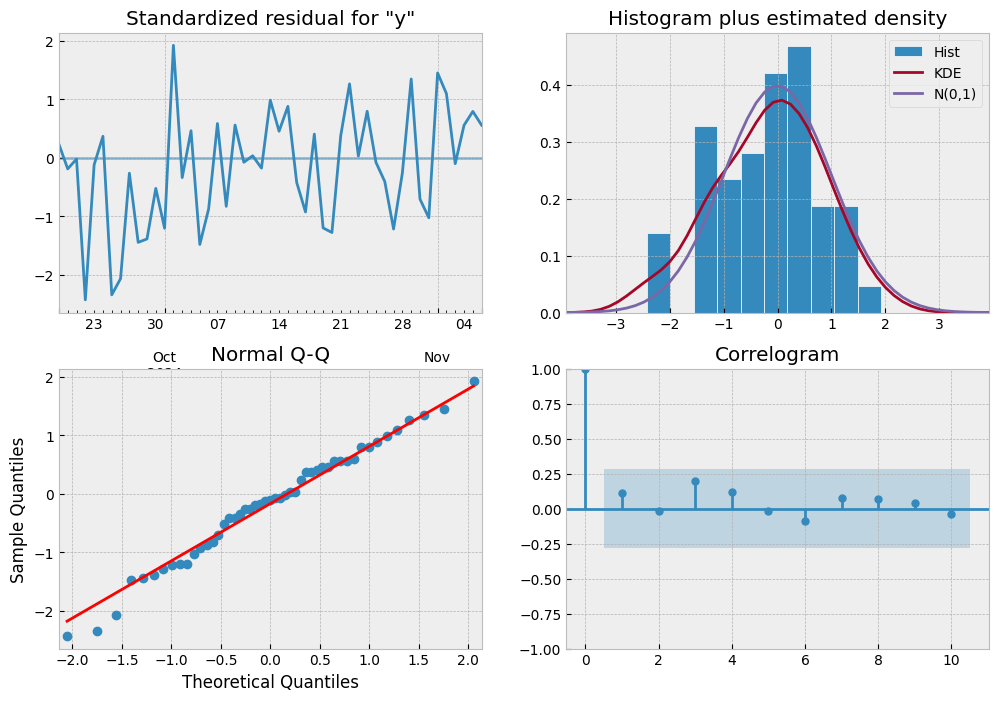

In [ ]:
# Fit SARIMA
arima_model = ARIMA(train, order=(0, 0, 0), seasonal_order=(3, 1, 0, 7)).fit()
arima_forecast = arima_model.forecast(steps=7)

# Display the summary of the models
arima_model.plot_diagnostics(figsize=(12, 8))
print(arima_model.summary())

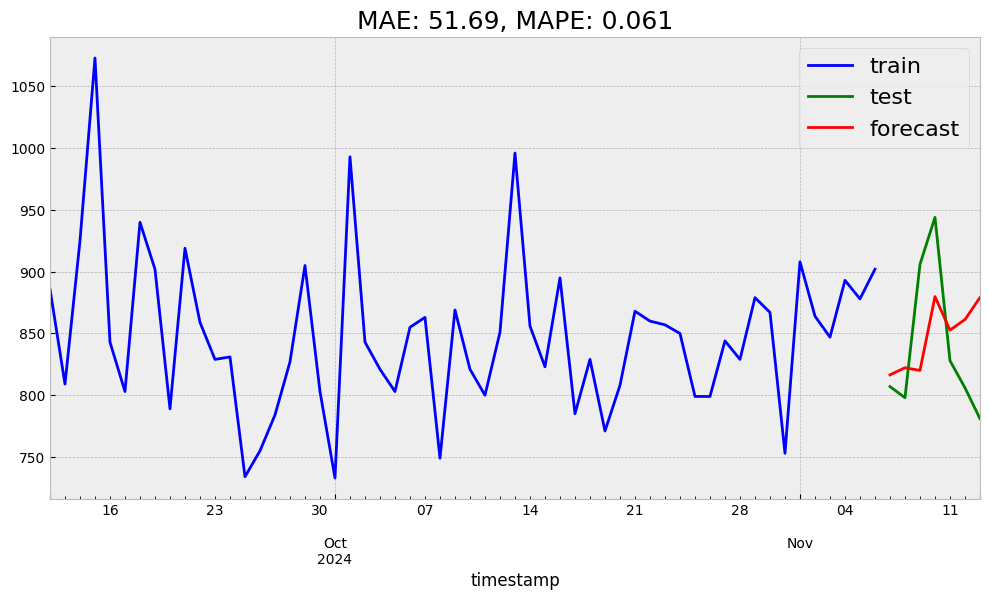

In [17]:
# Plot the forecast
mae_arima, mape_arima = plot_forecast(train, test, arima_forecast)

## Part 1B

### Procesing data to requied series

In [18]:
# Adding Date column to the dataframes
entry_df['date'] = (entry_df['timestamp'] - pd.to_timedelta(1, unit= 'sec')).dt.date
exit_df['date'] = (exit_df['timestamp'] - pd.to_timedelta(1, unit= 'sec')).dt.date

# Finding Mean time spent in the parking lot per day
common_df = pd.DataFrame(exit_df.groupby('date')['timestamp'].mean() - entry_df.groupby('date')['timestamp'].mean())
common_df['timestamp'] = common_df['timestamp'].dt.total_seconds() / 60

# Converting the time spent to series
timespent = pd.Series(common_df['timestamp'].values)


C:\Users\Tejeswar K\AppData\Local\Temp\ipykernel_15828\3882997380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entry_df['date'] = (entry_df['timestamp'] - pd.to_timedelta(1, unit= 'sec')).dt.date
C:\Users\Tejeswar K\AppData\Local\Temp\ipykernel_15828\3882997380.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit_df['date'] = (exit_df['timestamp'] - pd.to_timedelta(1, unit= 'sec')).dt.date


In [19]:
#Splitting the Data into train and test sets
train_size = len(timespent) - 7
train_timespent, test_timespent = timespent[:train_size], timespent[train_size:]

print("Train set size:", len(train_timespent))
print("Test set size:", len(test_timespent))

Train set size: 56
Test set size: 7


### Ploting the Data

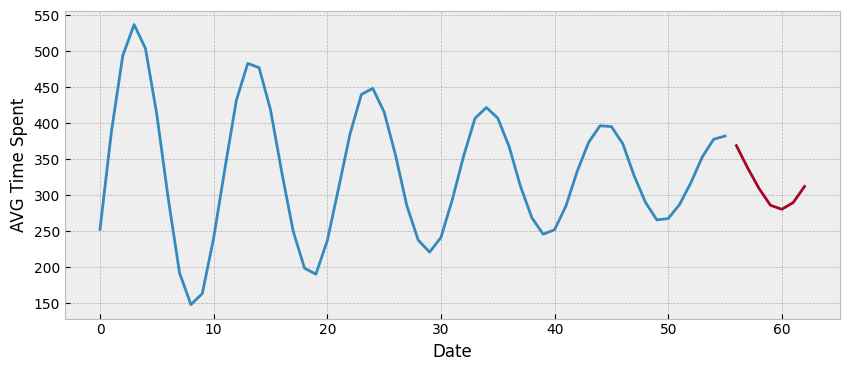

In [20]:
fig, ax = plt.subplots(figsize=(10, 4))
train_timespent.plot(ax =ax, label = 'Train Data')
test_timespent.plot(ax =ax, label = 'Test Data')
ax.set_xlabel('Date')
ax.set_ylabel('AVG Time Spent')
plt.show()

### Analysing for Corelation

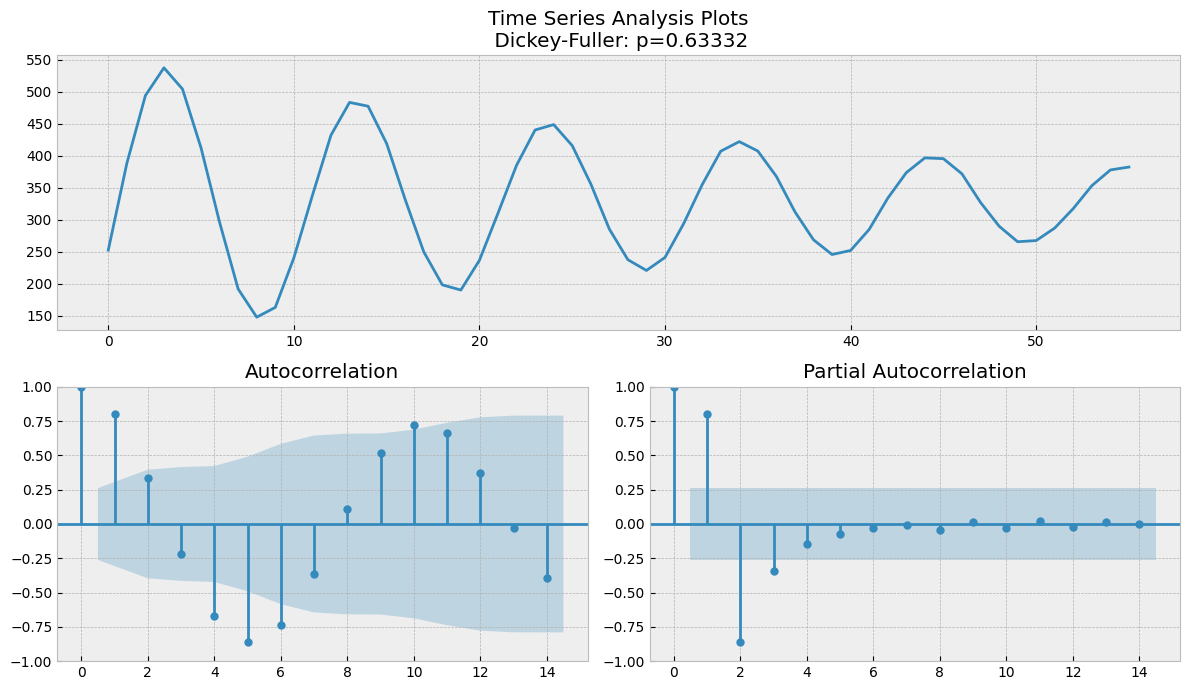

In [21]:
tsplot(train_timespent, lags=14)

The ADFuller Value is very High suggesting non-stationary behavior.

Lets Take the seasonal Difference to find any improvement in ADFuller Value

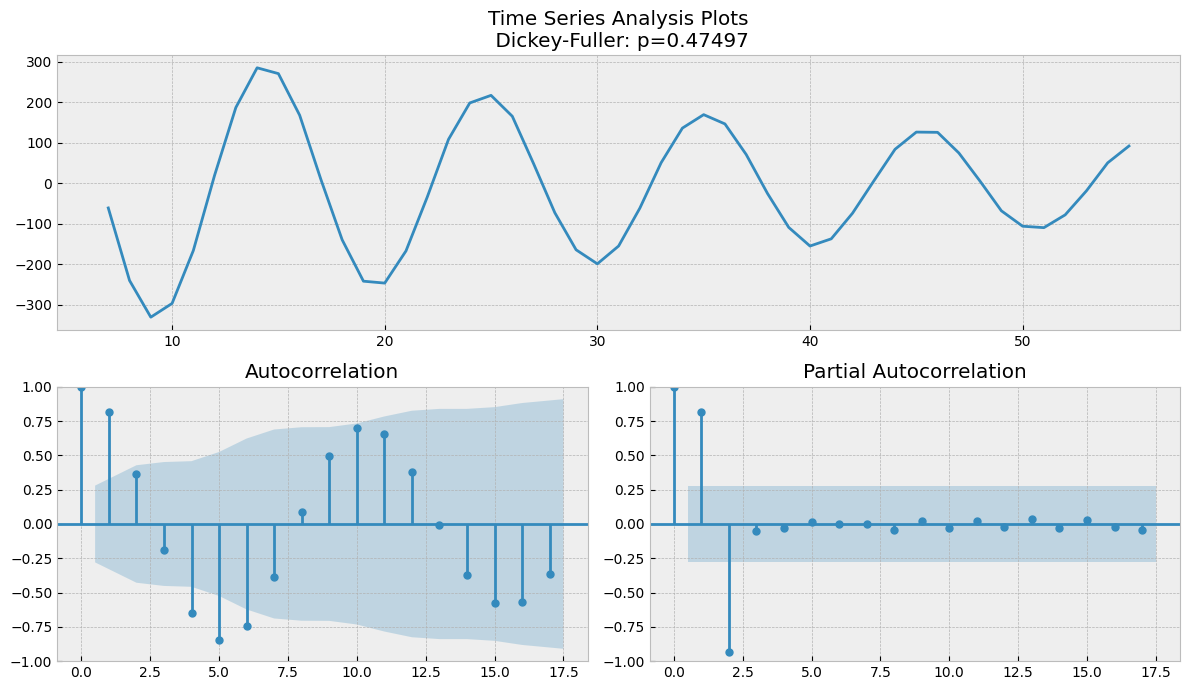

In [22]:
# Seasonal difference
train_diff = train_timespent - train_timespent.shift(7)
train_diff = train_diff.dropna()
tsplot(train_diff)

The Decrease in ADFuller Value is a good sign but it is still high letss try taking a normal diference at lag 1 over this data

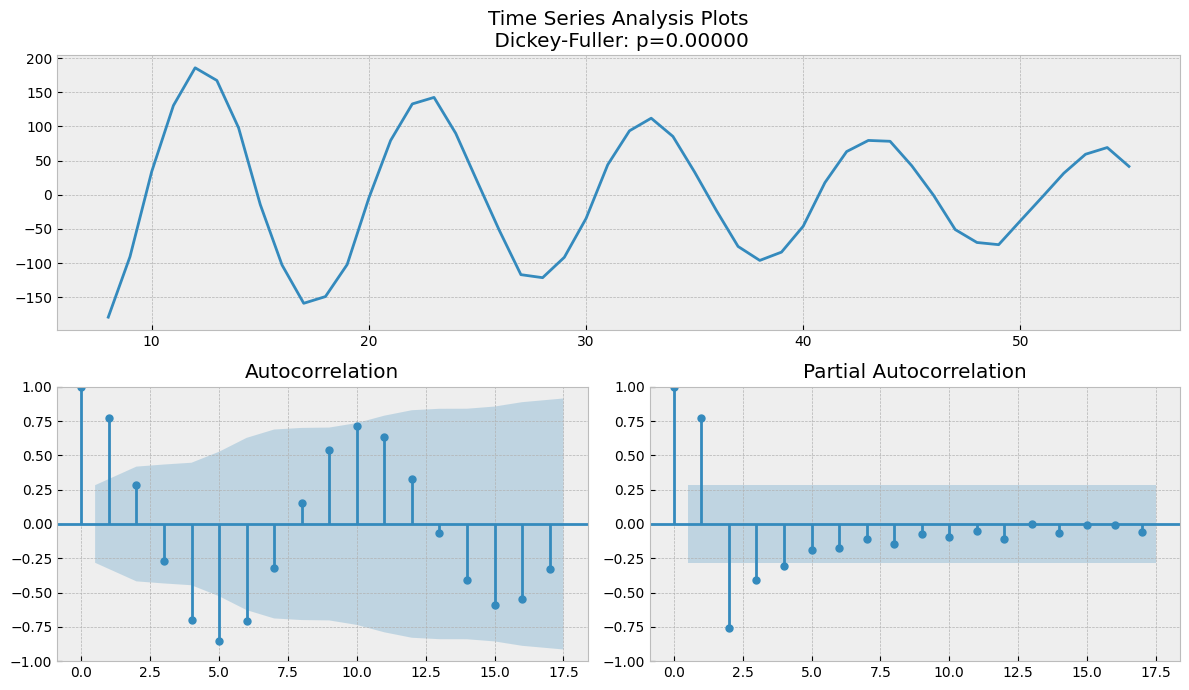

In [23]:
# Second Difference
train_diff_2 = train_diff - train_diff.shift(1)
train_diff_2 = train_diff_2.dropna()
tsplot(train_diff_2)

The Analysis suggest that our Data has d = 1

Since the ACF is sinusoidal and PACF drops below significance after lag 3, p = 3

## Fitting Models

1. **Auto_ARIMA**
2. **ARIMA**

**Auto ARIMA**

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[7] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=634.853, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=576.384, Time=0.17 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=633.209, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=582.575, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,0,0)(1,1,0)[7] intercept   : AIC=626.625, Time=0.11 sec
 ARIMA(2,0,0)(1,1,0)[7] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,0,1)(1,1,0)[7] intercept   : AIC=342.610, Time=0.50 sec
 ARIMA(2,0,1)(0,1,

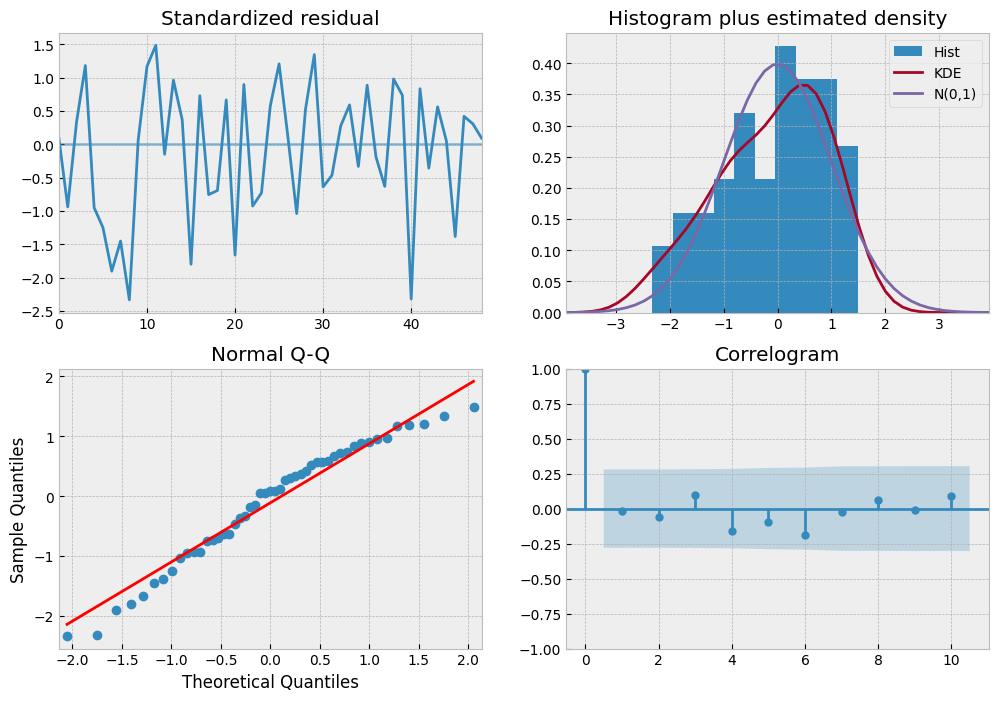

In [24]:
#fitting the auto_ARIMA model
Aarima_model_timespent = auto_arima(train_timespent, seasonal=True, m=7, trace=True)
Aarima_forecast_timespent = Aarima_model_timespent.predict(n_periods=len(test_timespent))

#Plot the summary of the model
Aarima_model_timespent.plot_diagnostics(figsize=(12, 8))
print(Aarima_model_timespent.summary())

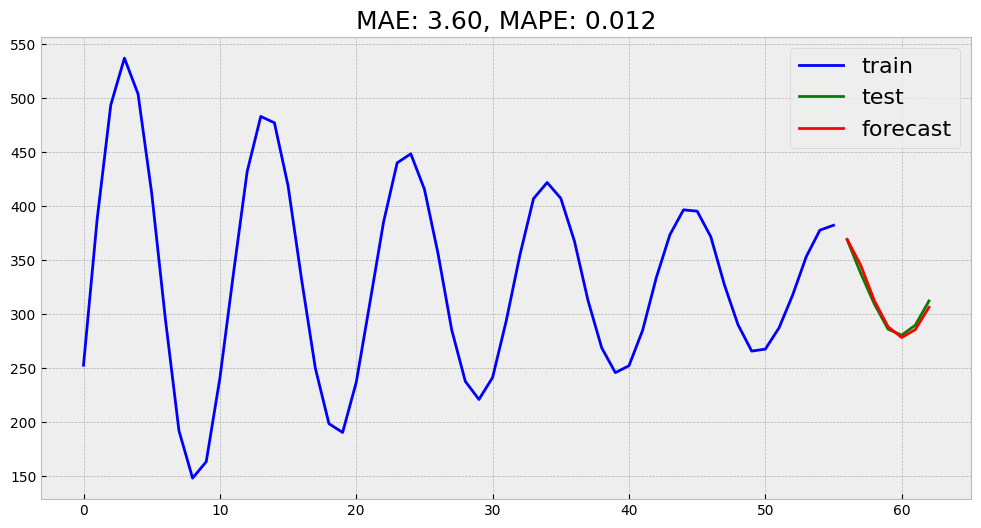

In [25]:
#Plot the forecast
Aarima_mae, Aarima_mape = plot_forecast(train_timespent, test_timespent, Aarima_forecast_timespent)

**ARIMA**

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   56
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -171.126
Date:                Sun, 19 Jan 2025   AIC                            350.251
Time:                        20:41:47   BIC                            358.280
Sample:                             0   HQIC                           353.356
                                 - 56                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9648      0.098      9.874      0.000       0.773       1.156
ar.L2          0.1099      0.161      0.684      0.494      -0.205       0.425
ar.L3         -0.6729      0.098     -6.878      0.0

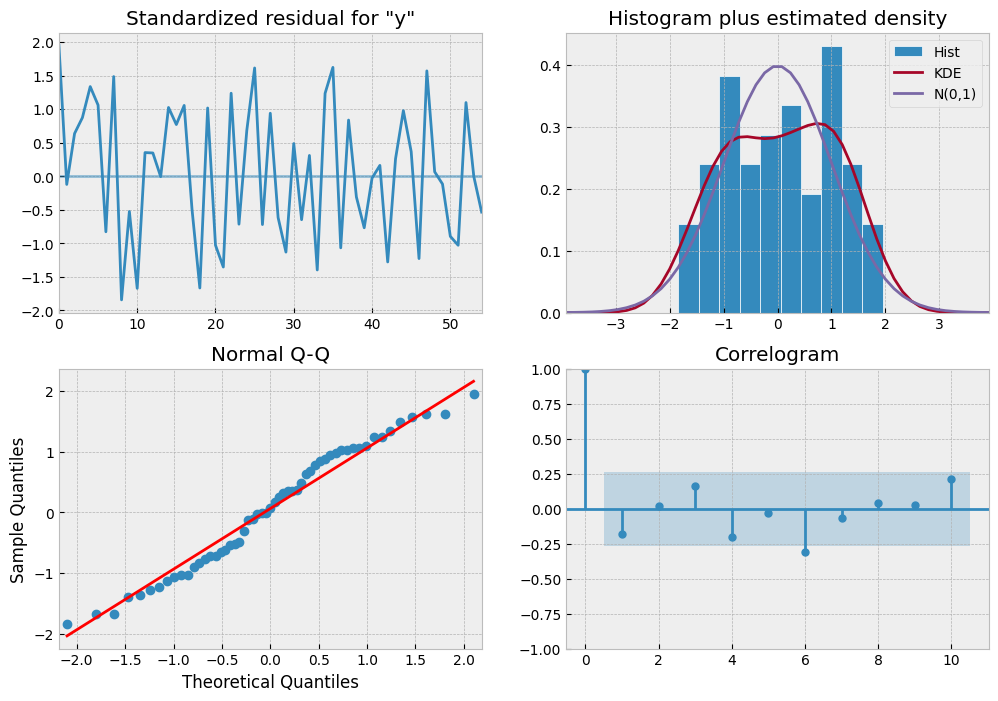

In [26]:
# Fit ARIMA(3,1,0) model
arima_model_timespent = ARIMA(train_timespent, order= (3,1,0)).fit()
arima_forecast_timespent = arima_model_timespent.forecast(steps= len(test_timespent))

# Plot the summary of the model
arima_model_timespent.plot_diagnostics(figsize=(12, 8))
print(arima_model_timespent.summary())

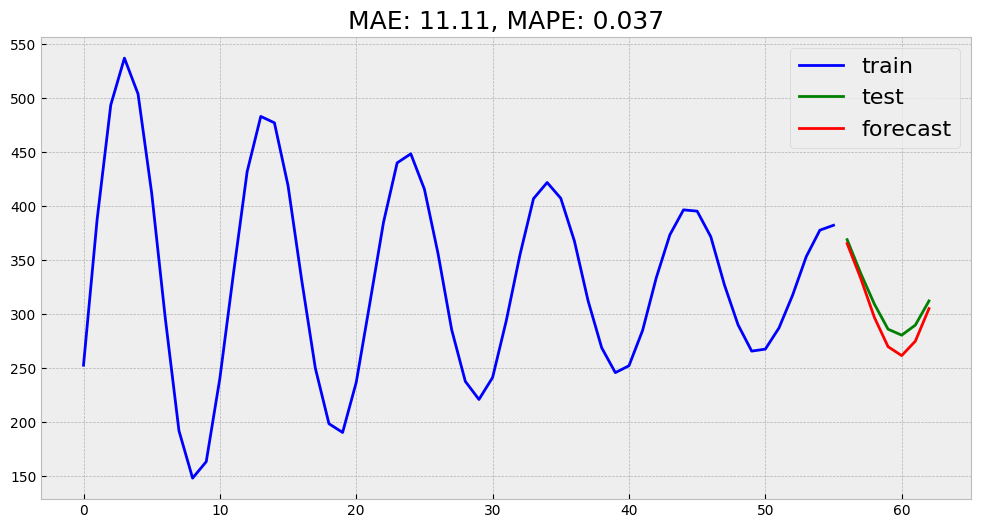

In [27]:
# Plot the forecast
arima_mae, arima_mape = plot_forecast(train_timespent, test_timespent, arima_forecast_timespent)

## Part 1C

### Possible Systematic errors

1. **Reporting Null due to Servicing**
2. **Working Hours are 5AM - 12AM(following day)**
3. **MisReading NumberPlate**
4. **Uploading in batches**

### Analysis
All the systematic expected errors(except due to pooling) just make a difference in the vehicle_no only either to null or some other.

our analysis doesnt care about which vehicle it is but rather only values the timestamp data irrespective of being which vehicle.

### Our Algorithm

1. **For Part 1A :** 

    We just count the total number of entries on the perticular day, irrespective of all the systematic errors the no.of vehicles is going to be the same. Hence the day_wise_df can be considered to be completely free of systematic deviations from real data

2. **For Part 1B :**

    We following algebra for finding the mean time spent per day


    **mean_time_spent**
    
    **= mean({exit time - entry time} for vehicle entered on the day)**

    **= mean({exit time} for vehicle on the day) - mean({entry time} for vehicle on the day)**


    By separating the means we have establisted that we dont need to map entry and exit time of vehicle rather we can just group by the data take mean and then subtract. (minor issue tobe fixed is counting 12AM into previous day)

    This algo to find the mean ensures that the vehicle no is used no where and most of the systematic errors are nullified

    To resolve the error due to uploading in batches we may assume a distribution of cars over the time slot, we expect it to be uniform and since we subtract the mean of entry and mean of exit over large enough set(which this is not) the contribution will be zero. But the deviation in series that arises due to this is also a random normal distribution (white noise)